In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import plot_model

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
!nvidia-smi

Mon Apr 26 12:10:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   70C    P0   119W / 150W |   6002MiB /  7618MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [6]:
base_dir = './pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

def make_blk(colar_pixel):
    test = np.mean(colar_pixel, axis=2, keepdims=True)
    test_array = np.concatenate([test,test,test], axis=2)
    return test_array

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2,
    preprocessing_function = make_blk
)

test_datagen = ImageDataGenerator(
     rescale=1/255,
     preprocessing_function = make_blk
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


# 전이 학습

In [7]:
# pretrained network
model_base = InceptionResNetV2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

activation_122 (Activation)     (None, 7, 7, 160)    0           batch_normalization_122[0][0]    
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 7, 7, 192)    208896      block17_11_ac[0][0]              
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 7, 7, 192)    215040      activation_122[0][0]             
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 7, 7, 192)    576         conv2d_120[0][0]                 
__________________________________________________________________________________________________
batch_normalization_123 (BatchN (None, 7, 7, 192)    576         conv2d_123[0][0]                 
__________________________________________________________________________________________________
activation

In [8]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1769600   
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
activation_203 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3

# Fine Tuning

In [9]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

"\nmodel_base.trainable=True\n\n# 상위 layer 동결해제\nfor layer in model_base.layers:\n    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:\n        layer.trainable=True\n    else:\n        layer.trainable=False\n\n# learning_rate 더 작게 설정\nmodel.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

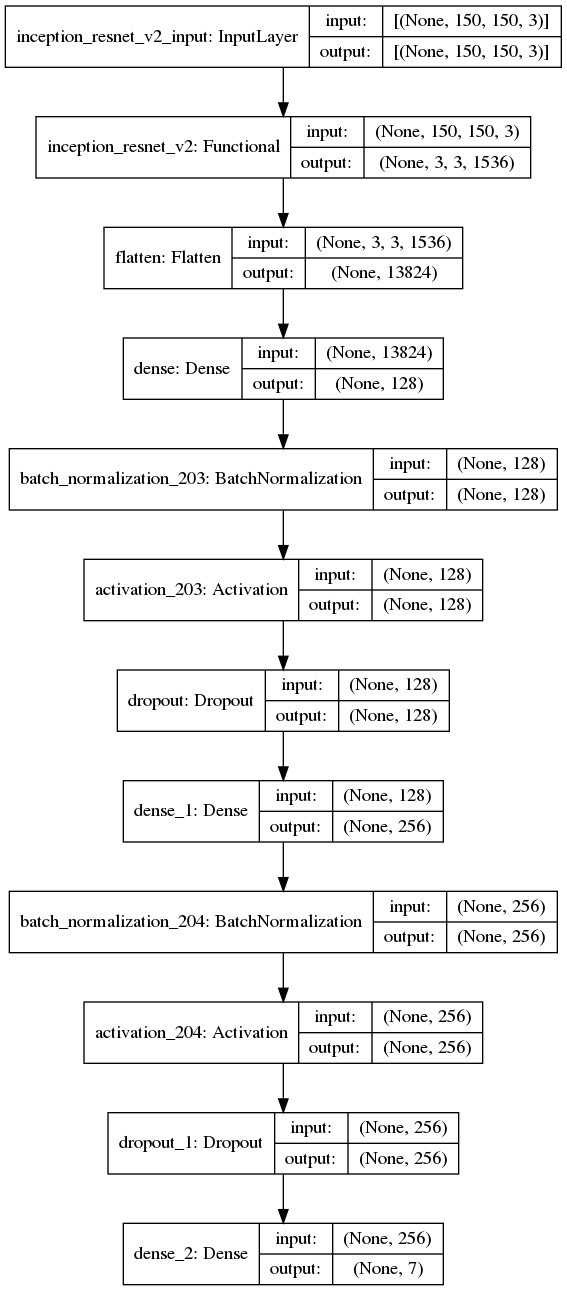

In [10]:
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/InceptionResNetV2_2/InceptionResNetV2_2-3.png')

In [11]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

Epoch 1/20
159/159 [==============================] - 180s 1s/step - loss: 2.2832 - accuracy: 0.2456 - val_loss: 1.6544 - val_accuracy: 0.3969
Epoch 2/20
159/159 [==============================] - 158s 996ms/step - loss: 1.7670 - accuracy: 0.3853 - val_loss: 1.5360 - val_accuracy: 0.4379
Epoch 3/20
159/159 [==============================] - 161s 1s/step - loss: 1.6443 - accuracy: 0.4281 - val_loss: 1.4758 - val_accuracy: 0.4541
Epoch 4/20
159/159 [==============================] - 161s 1s/step - loss: 1.5485 - accuracy: 0.4466 - val_loss: 1.4484 - val_accuracy: 0.4600
Epoch 5/20
159/159 [==============================] - 161s 1s/step - loss: 1.4510 - accuracy: 0.4800 - val_loss: 1.5433 - val_accuracy: 0.4149
Epoch 6/20
159/159 [==============================] - 148s 931ms/step - loss: 1.3812 - accuracy: 0.5032 - val_loss: 1.4235 - val_accuracy: 0.4751
Epoch 7/20
159/159 [==============================] - 118s 739ms/step - loss: 1.3289 - accuracy: 0.5194 - val_loss: 1.4605 - val_accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


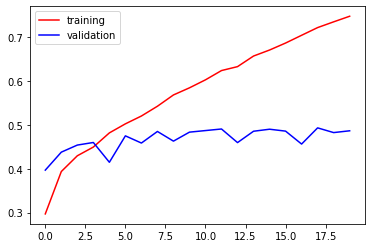

In [12]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_2/InceptionResNetV2_2-3_acc.jpg')
plt.show()

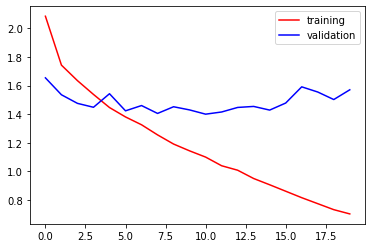

In [13]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
plt.savefig('./models/InceptionResNetV2_2/InceptionResNetV2_2-3_val.jpg')
plt.show()

In [14]:
result = model.evaluate(test_generator)
print(np.round(result, 4))

21/21 [==============================] - 15s 720ms/step - loss: 1.5040 - accuracy: 0.5101
[1.504  0.5101]


In [15]:
model.save('./models/InceptionResNetV2_2/InceptionResNetV2_2-3.h5')